In [33]:
import numpy as np
from qiskit import *
import matplotlib.pyplot as plt 
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# apitoken = '0ac08bc0e23b22dcff4888822d56241be15b0a64e77e94c42639a524404aafbc7df008ab6043e4706b3b82aa42f03c06464b3c253b92ddf1337e80048cf53be0'
# IBMQ.save_account(apitoken, overwrite = True)

[1, 7, 4, 13, 1, 7, 4, 13, 1, 7, 4, 13, 1, 7, 4, 13, 1, 7, 4, 13, 1, 7, 4, 13, 1]


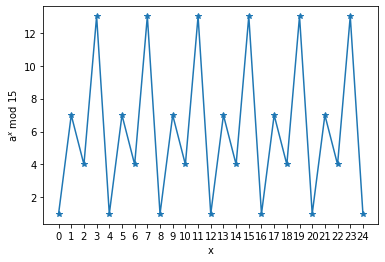

In [34]:
# Step 1 
def f(a, x):
    return a**x % 15

a = 7

y = []
for i in range(25):
    y.append(f(a, i))
print(y)
plt.plot(y, marker = '*')
plt.xticks(range(0, 25))
plt.xlabel('x')
plt.ylabel('a$^x$ mod 15')
plt.show()

In [50]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U
def qft_dagger(n):
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
        
    qc.name = "QFT"
    return qc

In [66]:
# Create QuantumCircuit with n_count counting qubits plus 4 qubits for U
#to act on

n_count = 8 # number of counting qubits
a = 13 # a variable that can be adjusted later


# The first 8-qubit register for storing x
qr1 = QuantumRegister(n_count, name="q1")
# The second 4-qubit register for storing f(x)
qr2 = QuantumRegister(4, name="q2")
cr1 = ClassicalRegister(n_count, name="c1")
# cr2 = ClassicalRegister(4, name="c2")
qc = QuantumCircuit(qr1, qr2, cr1)

# Initialize counting qubits in uniform superposition
for q in range(n_count):
    qc.h(q)
    
# And ancilla register in state |1>
qc.x(3+n_count)
# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q),
    [q] + [i+n_count for i in range(4)])
    
qc.append(qft_dagger(n_count), range(n_count))

qc.measure(range(n_count), range(n_count))
# qc.measure_all()
# qc.draw()

4


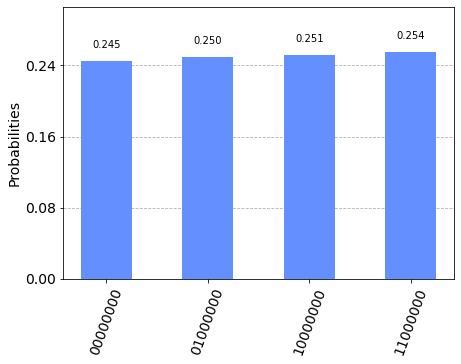

In [67]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots = 2048)
result = job.result()
counts = result.get_counts()
print(len(counts))
plot_histogram(counts)

In [68]:
import pandas as pd
from fractions import Fraction
rows, measured_phases = [], []

for output in counts:
    decimal = int(output, 2) # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)


   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.50      1/2            2
2   0.25      1/4            4
3   0.00      0/1            1
